@author: Valentin Larrieu

# Graph Mining

**Warning**: This notebook is made to work with NetworkX 2.X. Some problems may be encountered with older versions

In [1]:
import numpy as np
import random
import networkx as nx
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
import os.path
import urllib
import tarfile
from scipy.stats import binom
import warnings
import seaborn as sns
import pandas as pd
import itertools
from collections import Counter
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

/home/mickael/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## Graph analysis

### Erdős-Rényi

#### Plot of the data

We create a Erdős-Rényi graph with n=200 noeuds and p=0.04

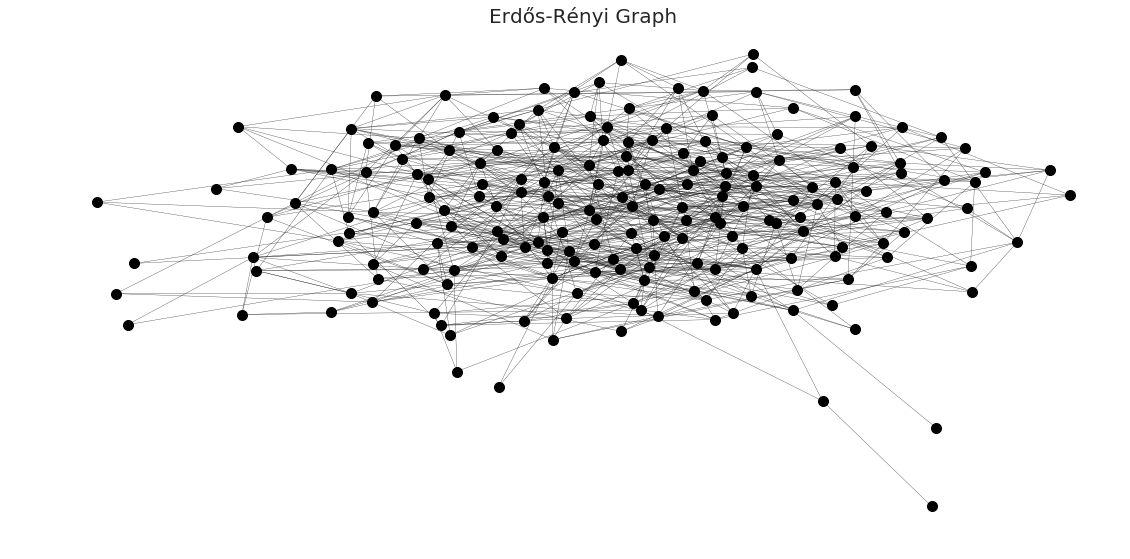

In [349]:
plt.figure(figsize=(15,7))
n = 200
p = 0.04
G_erdos = nx.erdos_renyi_graph(n = 200, p = 0.04)

options = {
    'node_color': 'black',
    'node_size': 100,
    'line_color': 'grey',
    'linewidths': 1,
    'width': 0.3,
}
nx.draw(G_erdos, **options)
plt.title("Erdős-Rényi Graph", fontsize=20)
plt.show()

#### Some statistics

Let's compute some statistics

In [350]:
degree_sequence_erdos = [val for (node, val) in G_erdos.degree()]
nb_nodes = G_erdos.number_of_nodes()
nb_edges = G_erdos.number_of_edges()
degree_mean = np.mean(degree_sequence_erdos)
degree_max = np.max(degree_sequence_erdos)
degree_min = np.min(degree_sequence_erdos)
degree_med = np.median(degree_sequence_erdos)

df_degree = pd.DataFrame(degree_sequence_erdos, columns = ["Degree"])
df_degree.index.name = "node"

In [351]:
print(" Graph Details ".center(70,"="))
print("Number of nodes :\t", nb_nodes)
print("Number of edges :\t", nb_edges)
print("\n")
print(" Table of degree per node ".center(70,"="))
print(df_degree.T)
print("\n")
print(" Degree statistics ".center(70,"="))

print(df_degree.describe().T)

=========================== Graph Details ============================
Number of nodes :	 200
Number of edges :	 770


====================== Table of degree per node ======================
node    0    1    2    3    4    5    6    7    8    9   ...   190  191  192  \
Degree    4    6    5    6    6    8    9   11    8    5 ...    13    6    5   

node    193  194  195  196  197  198  199  
Degree   11    2    5    8   12    6    6  

[1 rows x 200 columns]


========================= Degree statistics ==========================
        count  mean       std  min  25%  50%  75%   max
Degree  200.0   7.7  2.760089  1.0  6.0  8.0  9.0  18.0


We know that degree distribution for an Erdős-Rényi graph follows a binomial distribution $B(n,p)$ (n : number of nodes, p = 0.04). 

Let's calculate the mean and std of this law.

In [352]:
mean_bi, var_bi, _, _ = binom.stats(n, p, moments='mvsk')
print("Binomial mean:\t", mean_bi)
print("Binomean std:\t", round(np.sqrt(var_bi),2))

Binomial mean:	 8.0
Binomean std:	 2.77


We noticed that the std and mean of the graph is closed of the Binomial mean and standard deviation, which confirms that an Erdős-Rényi graph follows a binomial law. 

Moreover, we noticed that median and mean are closed seems to show the lack of outliers in our distribution. This seems to be confirmed by the fact that the max degree is 17 and that 75 % of degree are under 10. It is likely that the distribution histogram graph does not have a tail which is coherent with a binomial distribution in which the probability of a high degree decreses exponentially.

#### Degree Distribution

Let's plot degree distribution

In [353]:
# Let's calculate the frequency per degree 
degree_freq = np.array(nx.degree_histogram(G_erdos))
num_deg = len(degree_freq)

# Let's define the binomial frequency distribution B(n,p). 
# We multiply it by n in order to be on same scale than the degree_histogram
binomial = binom.pmf(np.arange(num_deg),n,p)*n

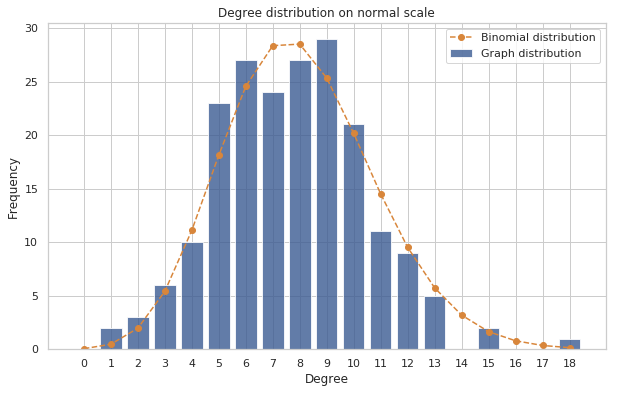

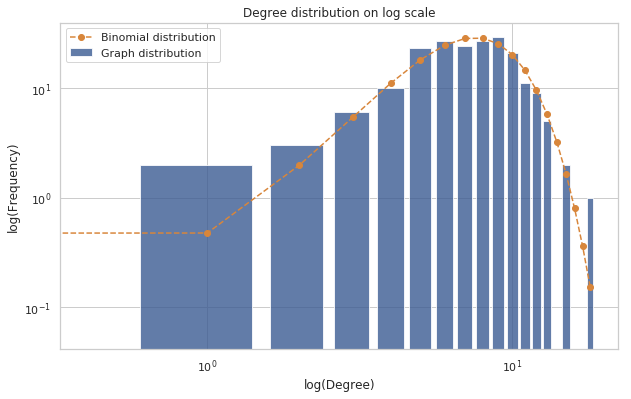

In [354]:
# let's plot the degree distribution (frequency = f(k)) 
plt.figure(figsize=(10, 6))
plt.bar(x = np.arange(num_deg),height = degree_freq, 
        color=sns.xkcd_rgb["denim blue"], alpha = 0.8,label ="Graph distribution")
plt.plot(np.arange(num_deg),binomial,"o--",
         color =sns.xkcd_rgb["dull orange"], label = "Binomial distribution")
plt.legend()
plt.ylabel("Frequency")
plt.xlabel("Degree")
plt.xticks(np.arange(num_deg))
plt.title("Degree distribution on normal scale")
plt.show()

# Let's plot the log - log graph 
plt.figure(figsize=(10, 6))
plt.bar(x = np.arange(num_deg),height = degree_freq, 
        color=sns.xkcd_rgb["denim blue"], alpha = 0.8,label ="Graph distribution")
plt.plot(np.arange(num_deg),binomial,"o--",
         color =sns.xkcd_rgb["dull orange"], label = "Binomial distribution")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.ylabel("log(Frequency)")
plt.xlabel("log(Degree)")
plt.title("Degree distribution on log scale")
plt.show()

The plot of the graph follow the theoritical graph ofthe binomial distribution with some differences which can be explained that our dataset is too small to converge perfectly to the binomial law. 
the log plot also show the exponential decrease of the probability once we pass the mean, explaining why we do not found nodes with high degrees in our Erdős-Rényi graph 

#### Global clustering

We compute the global clustering value

In [355]:
global_clustering = np.mean(list(nx.clustering(G_erdos).values()))
print("Global clustering value: \t", round(global_clustering,3))

Global clustering value: 	 0.033


Theoritically, the global clustering coefficient for an Erdős-Rényi graph is p(=0.04). 
Therefore, our calculated value is coherent.

#### Shortest path and diameter

We show shortest path and diameter

In [356]:
mean_shortest_path = nx.average_shortest_path_length(G_erdos)
longest_shortest_path = nx.diameter(G_erdos)
nb_components = nx.number_connected_components(G_erdos)
# Since this give us a nested dictionarry of (source:Target:shortest_path
# We want the list of  shortest path between nodes, thefore, to avoid redundacy
# We will do the following
list_shortest_path = []
dict_shortest_path = dict(nx.shortest_path_length(G_erdos))
for source, dict_source_shortest_path in dict_shortest_path.items():
    for target, shortest_path in dict_source_shortest_path.items():
        if target > source : 
            list_shortest_path.append(shortest_path)

In [357]:
# To double check or list , we can compare the max and the mean with the expected value
print(" Check of our list ".center(70,"="))
print("Mean Shortest path (from netorkx function):\t ",round(mean_shortest_path,5))
print("Mean Shortest path (from shortest path list):\t ",round(np.mean(list_shortest_path),5))
print("Longest Shortest path (from netorkx function):\t ",round(longest_shortest_path,5))
print("Longest Shortest path (from shortest path list):\t ",round(max(list_shortest_path),5))

========================= Check of our list ==========================
Mean Shortest path (from netorkx function):	  2.81276
Mean Shortest path (from shortest path list):	  2.81276
Longest Shortest path (from netorkx function):	  6
Longest Shortest path (from shortest path list):	  6


It seems that our list is correct since it is coherent with the expected value for mean and max.  Let's preview the distribution of the shortest path

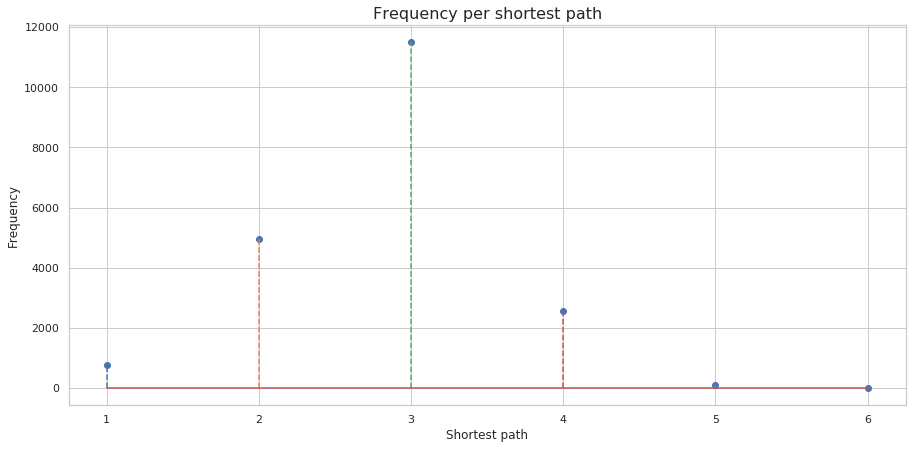

=================== Graph Shortest Path Statistics ===================
Mean Shortest path :	 2.81276
Max Shortest path :	 6
Number components:	 1


In [358]:
distrib_shortest_path = Counter(list_shortest_path)
plt.figure(figsize=(15,7))
plt.stem( distrib_shortest_path.keys(), distrib_shortest_path.values(),linefmt = "--")
plt.xticks(np.arange(1,longest_shortest_path+1))
plt.xlabel("Shortest path")
plt.ylabel("Frequency")
plt.title("Frequency per shortest path", fontsize=16)
plt.show()

print(" Graph Shortest Path Statistics ".center(70,"="))
print("Mean Shortest path :\t",round(mean_shortest_path,5))
print("Max Shortest path :\t",round(longest_shortest_path,5))
print("Number components:\t", nb_components)

__Conclusion__:

Our graph is composed of only 1 components, meaning that every node is connected(via a path) to another node. With the given average & longest shortest path, we can say that our graph is subject to the small-world phenomenon even if there is not "hubs" nodes (node with high degree)

### Barabási–Albert

#### Question 6

We create a Barabási–Albert graph with n=200

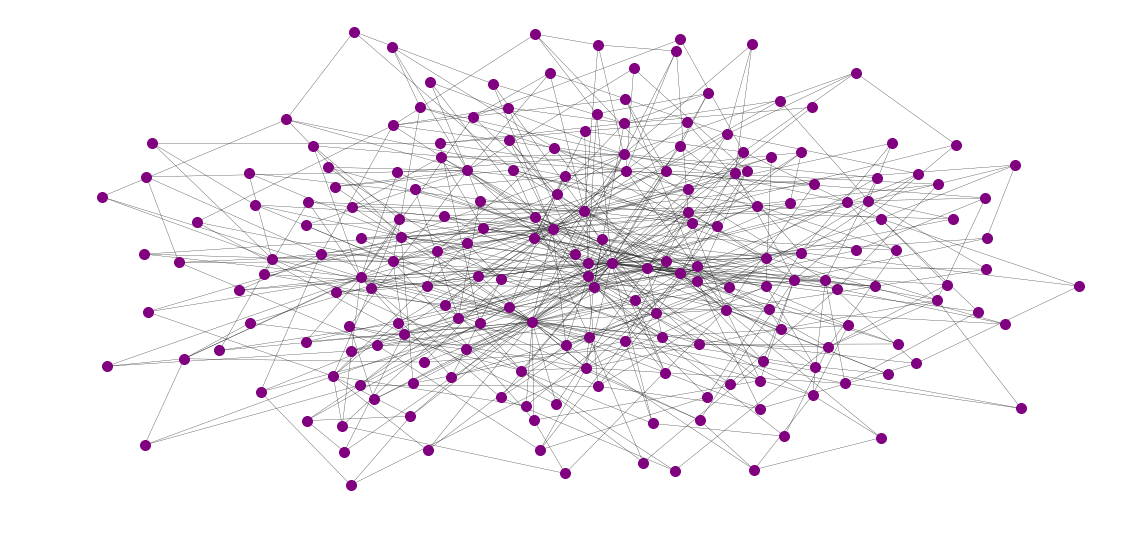

In [368]:
plt.figure(figsize=(15,7))
n = 200
m = 3
G_barabasi = nx.barabasi_albert_graph(n = 200, m = 3)
options = {
    'node_color': 'purple',
    'node_size': 100,
    'line_color': 'purple',
    'linewidths': 1,
    'width': 0.3,
}
nx.draw(G_barabasi, **options)
plt.show()

In [369]:
degree_sequence_barabasi = [val for (node, val) in G_barabasi.degree()]
nb_nodes2 = G_barabasi.number_of_nodes()
nb_edges2 = G_barabasi.number_of_edges()
degree_mean2 = np.mean(degree_sequence_barabasi)
degree_max2 = np.max(degree_sequence_barabasi)
degree_min2 = np.min(degree_sequence_barabasi)
degree_med2 = np.median(degree_sequence_barabasi)

df_degree2 = pd.DataFrame(degree_sequence_barabasi, columns = ["Degree"])
df_degree2.index.name = "node"

In [370]:
print(" Graph Details ".center(70,"="))
print("Number of nodes :\t", nb_nodes2)
print("Number of edges :\t", nb_edges2)
print("\n")
print(" Table of degree per node ".center(70,"="))
print(df_degree2.T)
print("\n")
print(" Degree statistics ".center(70,"="))

print(df_degree2.describe().T)

=========================== Graph Details ============================
Number of nodes :	 200
Number of edges :	 591


====================== Table of degree per node ======================
node    0    1    2    3    4    5    6    7    8    9   ...   190  191  192  \
Degree   25   34    2   47   45   25   10   15   13    8 ...     3    3    3   

node    193  194  195  196  197  198  199  
Degree    3    3    3    3    3    3    3  

[1 rows x 200 columns]


========================= Degree statistics ==========================
        count  mean       std  min  25%  50%  75%   max
Degree  200.0  5.91  5.945472  2.0  3.0  4.0  6.0  47.0


Comments about the fact the max is high and therefore there is hiub and we will proabably see a tail in the distribution 

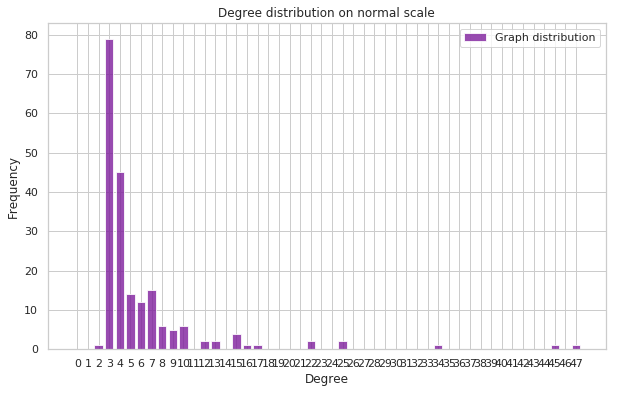

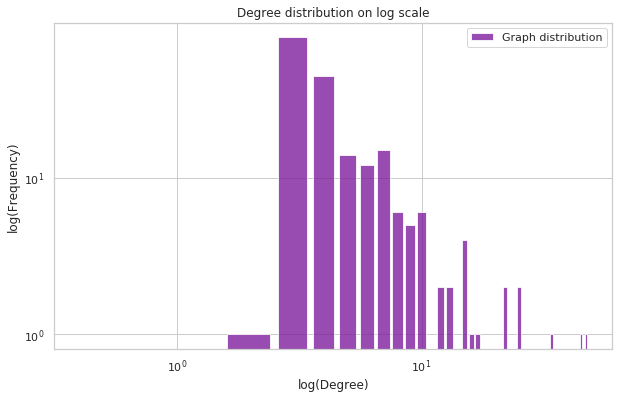

In [371]:
# Let's calculate the frequency per degree 
degree_freq2 = np.array(nx.degree_histogram(G_barabasi))
num_deg2 = len(degree_freq2)

# let's plot the degree distribution (frequency = f(k)) 
plt.figure(figsize=(10, 6))
plt.bar(x = np.arange(num_deg2),height = degree_freq2, 
        color=sns.xkcd_rgb["purple"], alpha = 0.8,label ="Graph distribution")
plt.legend()
plt.ylabel("Frequency")
plt.xlabel("Degree")
plt.xticks(np.arange(num_deg2))
plt.title("Degree distribution on normal scale")
plt.show()

# Let's plot the log - log graph 
plt.figure(figsize=(10, 6))
plt.bar(x = np.arange(num_deg2),height = degree_freq2, 
        color=sns.xkcd_rgb["purple"], alpha = 0.8,label ="Graph distribution")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.ylabel("log(Frequency)")
plt.xlabel("log(Degree)")
plt.title("Degree distribution on log scale")
plt.show()

In [372]:
# Let's calculate the global clustering
global_clustering2 = np.mean(list(nx.clustering(G_barabasi).values()))
print("Global clustering value: \t", round(global_clustering2,3))

Global clustering value: 	 0.104


In [373]:
mean_shortest_path2 = nx.average_shortest_path_length(G_barabasi)
longest_shortest_path2 = nx.diameter(G_barabasi)
nb_components2 = nx.number_connected_components(G_barabasi)
list_shortest_path2 = []
dict_shortest_path2 = dict(nx.shortest_path_length(G_barabasi))
for source, dict_source_shortest_path in dict_shortest_path2.items():
    for target, shortest_path in dict_source_shortest_path.items():
        if target > source : 
            list_shortest_path2.append(shortest_path)

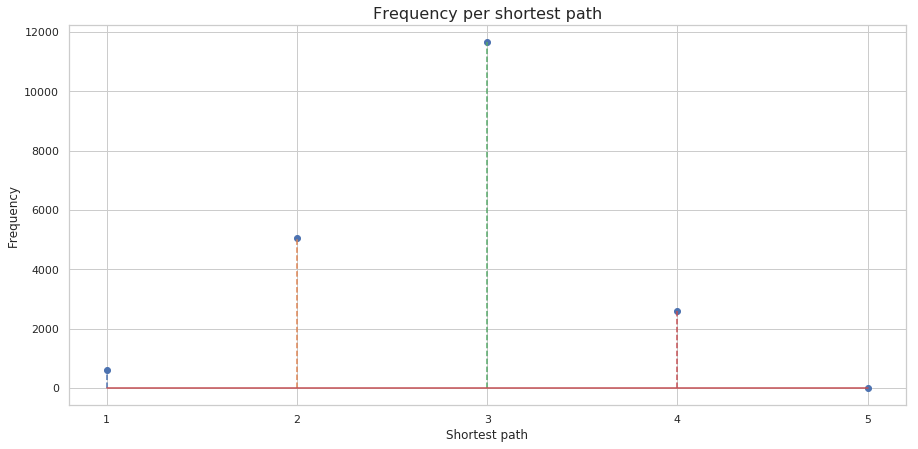

=================== Graph Shortest Path Statistics ===================
Mean Shortest path :	 2.81859
Max Shortest path :	 5
Number components:	 1


In [375]:
distrib_shortest_path2 = Counter(list_shortest_path2)
plt.figure(figsize=(15,7))
plt.stem(distrib_shortest_path2.keys(), distrib_shortest_path2.values(),linefmt = "--")
plt.xticks(np.arange(1,longest_shortest_path2+1))
plt.xlabel("Shortest path")
plt.ylabel("Frequency")
plt.title("Frequency per shortest path", fontsize=16)
plt.show()

print(" Graph Shortest Path Statistics ".center(70,"="))
print("Mean Shortest path :\t",round(mean_shortest_path2,5))
print("Max Shortest path :\t",round(longest_shortest_path2,5))
print("Number components:\t", nb_components2)

__Small World Phenomenom__: 

For same reason, we see that the Barabási–Albert is subject to the small world phenomenom as well.

__Comparison Barabási–Albert and Erdős-Rényi__ :

The main difference between Barabasi and Erdos graph is that Babarasi allows the possibility of high degree node ("hubs") which explains the tail that can be seen in the Barabasi distribution. 
Since there is high degree node, that the global clustering value is higher in a Babarasi graph.

##  Karate Club Graph

Let's work on a real graph (n=34, m=78). It represents friend link between people registered in a karate club

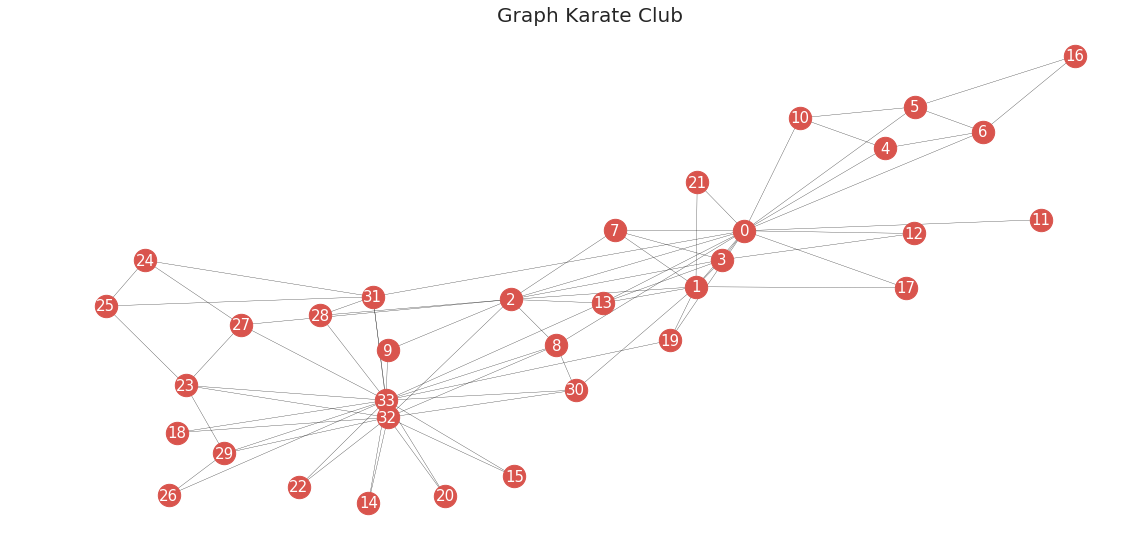

In [3]:
fig = plt.figure(figsize=(15,7))
n=34
G_karate = nx.karate_club_graph()

options = {
    'node_color': sns.xkcd_rgb["pale red"],
    'node_size': 500,
    'line_color': 'purple',
    'font_color': 'white',
    'font_size': 15,
    'linewidths': 1,
    'width': 0.3,
}

# on définit une position des noeuds qui peut être ré-utilisée plusieurs fois
# en appelant la fonction nx.draw avec l'option pos=pos

pos = nx.spring_layout(G_karate)
nx.draw(G_karate, cmap = plt.get_cmap('rainbow'), with_labels=True, pos=pos,**options)
plt.title("Graph Karate Club", fontsize=20)
plt.show()

#### Hierarchical clustering

We apply hierarchical clustering to our graph

In [4]:
pcc_longueurs=dict(nx.all_pairs_shortest_path_length(G_karate))
distances=np.zeros((n,n))

for i in range(n):
    for j in range(n):
        distances[i, j] = pcc_longueurs[i][j]

The bottom-up hierarchical clustering implementation of `scikit-learn` with the *average link* can now be used as a measure of dissimilarity between clusters. First of all, we display the clustering with 4 clusters

with 4 clusters:
link type:  complete


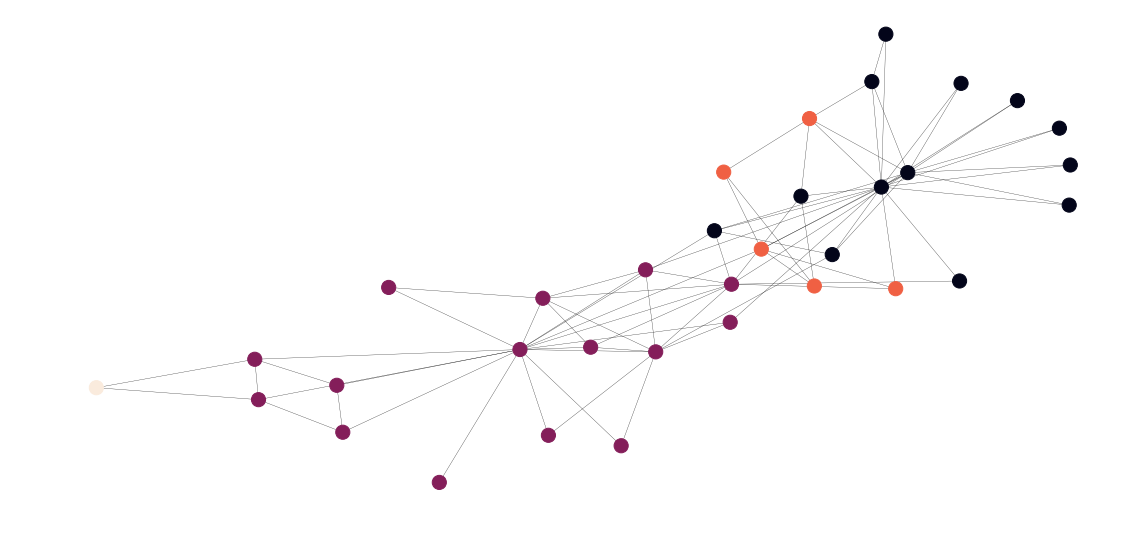

link type:  average


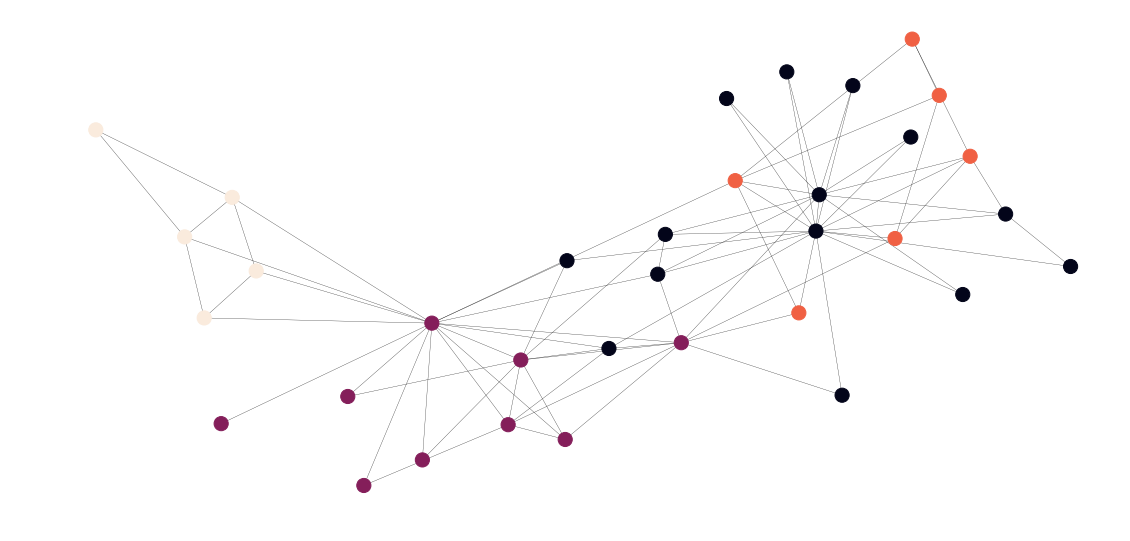

link type:  single


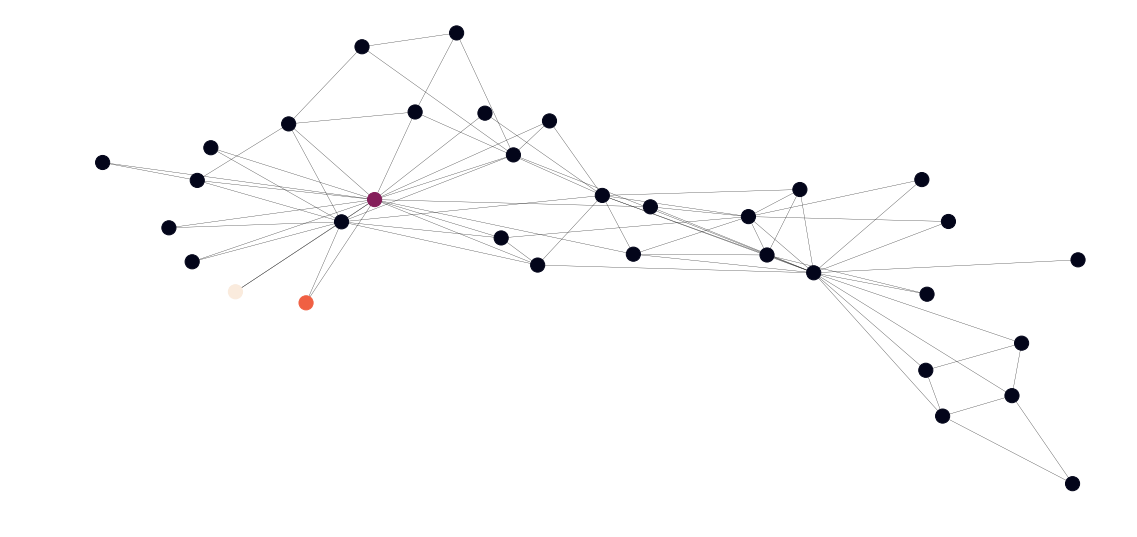

In [13]:
from sklearn.cluster import AgglomerativeClustering

print("with 4 clusters:")
link_list = ['complete', 'average', 'single']
options = {
    'node_size': 200,
    'line_color': 'purple',
    'font_color': 'white',
    'font_size': 15,
    'linewidths': 1,
    'width': 0.3,
}
for link in link_list:
    print("link type: ", link)
    ac = AgglomerativeClustering(affinity='precomputed', linkage = link,  n_clusters=4)
    ac.fit(distances)
    plt.figure(figsize=(15,7))
    nx.draw(G_karate, node_color= ac.labels_,**options)
    plt.show()


with 2 clusters:
link type:  complete


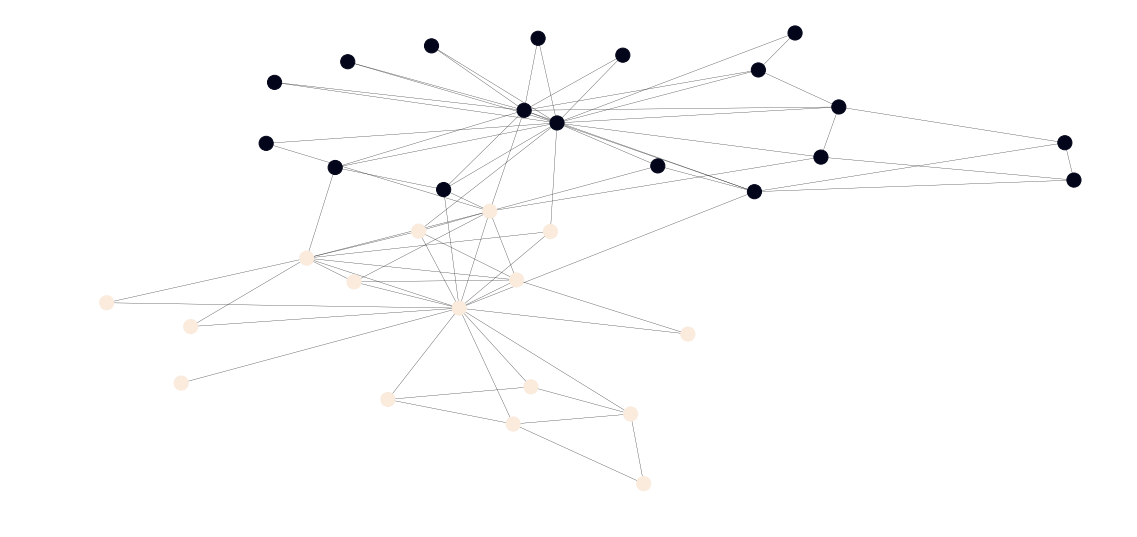

link type:  average


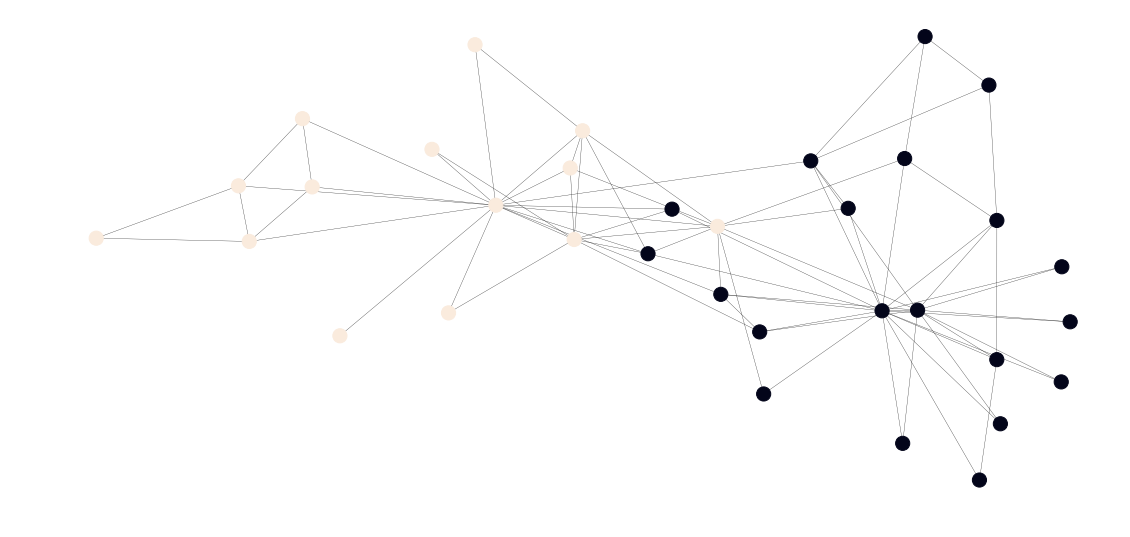

link type:  single


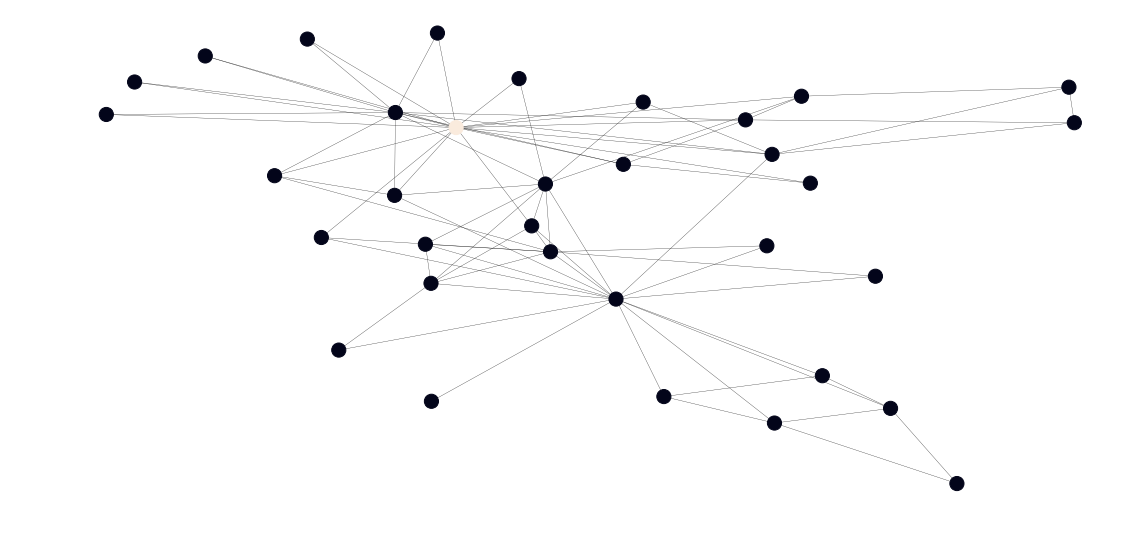

In [14]:
print("with 2 clusters:")
link_list = ['complete', 'average', 'single']
for link in link_list:
    print("link type: ", link)
    ac = AgglomerativeClustering(affinity='precomputed', linkage = link,  n_clusters=2)
    ac.fit(distances)
    plt.figure(figsize=(15,7))
    nx.draw(G_karate, node_color= ac.labels_, **options)
    plt.show()

#### Question 8

On va mettre en évidence visuellement les différences entre quelques mesures de centralité des noeuds

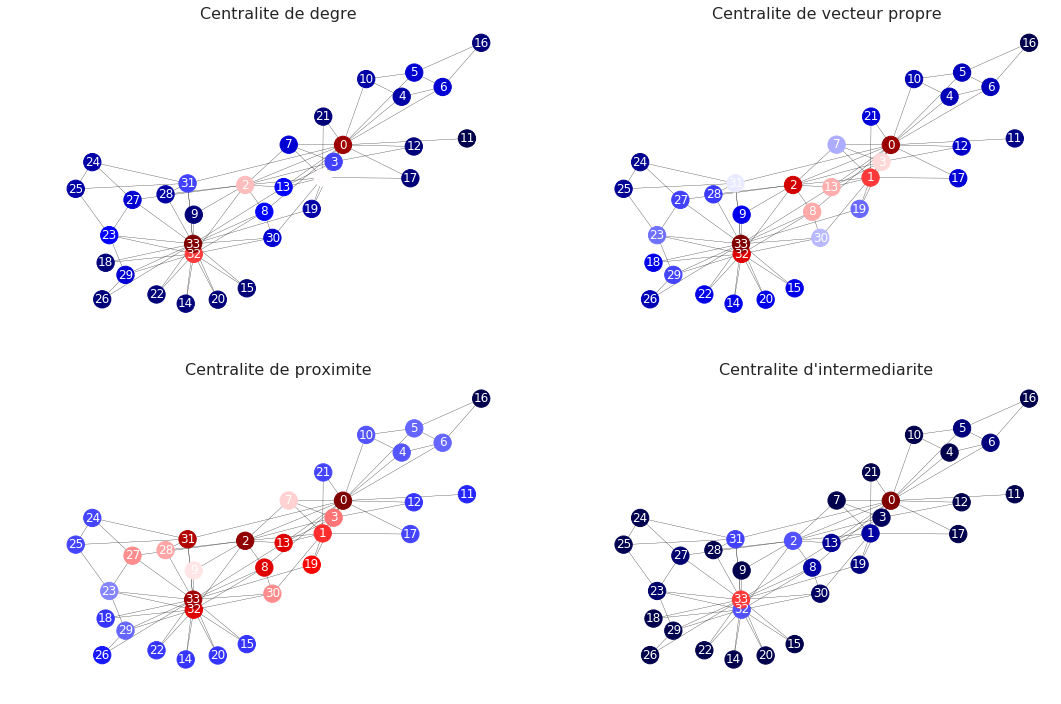

In [67]:
c_degree = list(dict(nx.degree(G_karate)).values())
c_eigenvector = list(nx.eigenvector_centrality(G_karate).values())
c_closeness = list(nx.closeness_centrality(G_karate).values())
c_betweenness = list(nx.betweenness_centrality(G_karate).values())

options = {
    'node_size': 300,
    'line_color': 'grey',
    'font_color': 'white',
    'font_size': 12,
    'linewidths': 1,
    'width': 0.3,
    'cmap': plt.get_cmap('seismic'),
    'with_labels' : True,
    'pos' : pos
}

plt.figure(figsize=(18, 12))
f, axarr = plt.subplots(2, 2, num=1)
plt.sca(axarr[0,0])
nx.draw(G_karate, node_color = c_degree,**options)
axarr[0,0].set_title('Centralite de degre', size=16)

plt.sca(axarr[0,1])
nx.draw(G_karate, node_color = c_eigenvector, **options)
axarr[0,1].set_title('Centralite de vecteur propre', size=16)

plt.sca(axarr[1,0])
nx.draw(G_karate, node_color = c_closeness,**options)
axarr[1,0].set_title('Centralite de proximite', size=16)

plt.sca(axarr[1,1])
nx.draw(G_karate, node_color = c_betweenness,**options)
axarr[1,1].set_title('Centralite d\'intermediarite', size=16)
plt.show()

## Amazon Graph

#### Question 9 (bonus +2 pts)

We will now study a large graph whose nodes are products sold by Amazon, and two nodes are connected if the two products are frequently purchased together (more details [here](https://snap.stanford.edu/data/com-Amazon.html))

In [90]:
# if os.path.exists('amazon.txt.gz') is False:
#     resp = urllib.urlretrieve('https://snap.stanford.edu/data/bigdata/' +
#                               'communities/com-amazon.ungraph.txt.gz', 'amazon.txt.gz')
G_amazon = nx.read_edgelist('amazon.txt.gz')

In [96]:
# number node and edges
nb_nodes_amz = G_amazon.number_of_nodes()
nb_edges_amz = G_amazon.number_of_edges()

# Frequency per degree
degree_freq_amz = np.array(nx.degree_histogram(G_amazon))
num_deg_amz = len(degree_freq_amz)
mean_degree = np.mean(degree_freq_amz)

# Dictionaries of clusterting per nodes 
dic_clustering_per_node_amz = nx.clustering(G_amazon)
# Dictionnaries of degree per nodes
dic_degree_per_node_amz = dict(nx.degree(G_amazon))
# Creation of dataframe of average clusteting per degree
s1 = pd.Series(dic_clustering_per_node_amz)
s2 = pd.Series(dic_degree_per_node_amz)
df_node_info_amz = pd.concat([s1, s2], 
                             axis=1).rename(index = int, 
                                            columns = {0:"clustering",1:"degree"}).sort_index()
df_clus_per_degree_amz = df_node_info.groupby(["degree"]).mean()

#Small world Phenomenon
nb_components_amz = nx.number_connected_components(G_amazon)
global_clustering_amz = np.mean(list(nx.clustering(G_amazon).values()))

========================== Graph Statistics ==========================
Number of nodes :	 334863
Number of edges :	 925872
Number of components :	 1
Average Clustering :	 0.397


             mean    std  min  25%    50%    75%    max
clustering  0.397  0.330  0.0  0.1  0.333  0.667    1.0
degree      5.530  5.762  1.0  3.0  4.000  6.000  549.0


No handles with labels found to put in legend.


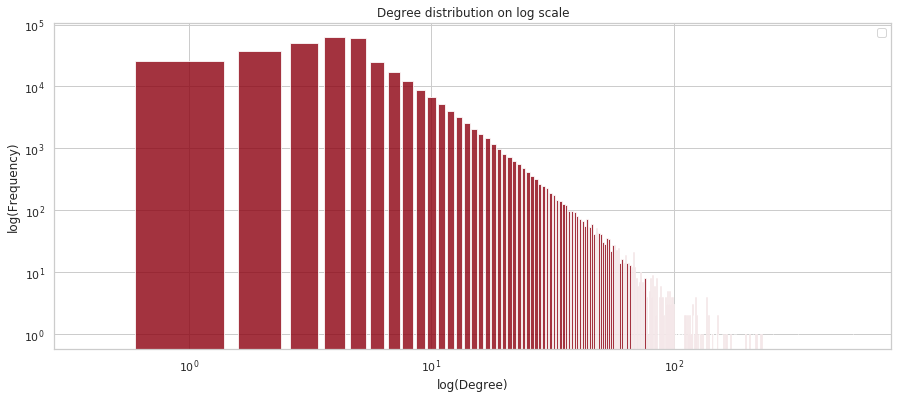

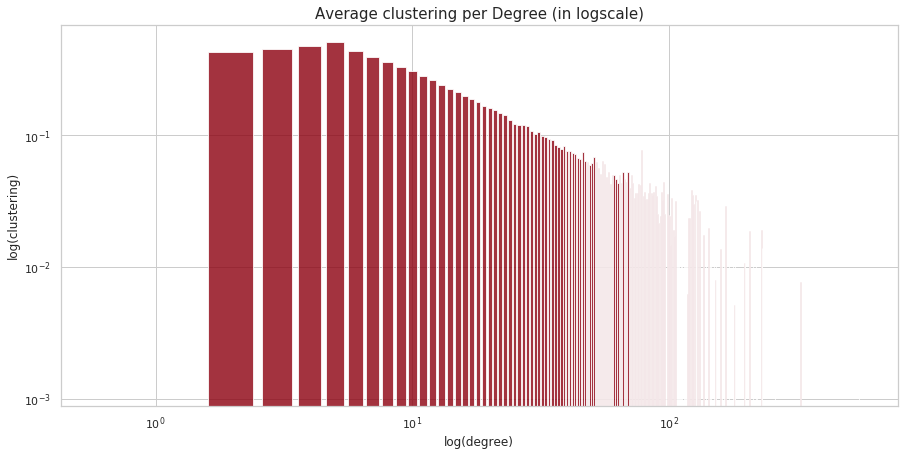

In [122]:
print(" Graph Statistics ".center(70,"="))
print("Number of nodes :\t", nb_nodes)
print("Number of edges :\t", nb_edges)
print("Number of components :\t", nb_components_amz)
print("Average Clustering :\t", round(global_clustering_amz,3))
print("\n")
print(df_node_info_amz.describe().drop(["count"]).T.round(3))


# Let's plot the log - log graph 
plt.figure(figsize=(15, 6))
plt.bar(x = np.arange(num_deg),height = degree_freq, 
        color=sns.xkcd_rgb["crimson"],alpha=0.8)
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.ylabel("log(Frequency)")
plt.xlabel("log(Degree)")
plt.title("Degree distribution on log scale")
plt.show()

plt.figure(figsize=(15,7))
plt.bar(x = df_clus_per_degree.index.values,height = df_clus_per_degree.clustering.values, 
        color=sns.xkcd_rgb["crimson"],alpha=0.8)
plt.title("Average clustering per Degree (in logscale)", fontsize=15)
plt.xlabel("log(degree)")
plt.ylabel("log(clustering)")
plt.xscale("log")
plt.yscale("log")
# plt.xlim(left =0 )
# plt.xlim(right=15)

plt.show()

### Observation

__Small World Phenomenon :__
    
Due to the voluminous size of the graph, we could not make the same analysis as previously (histogramme of shortest path). However, we noticed that the average degree and global clustering is higher in the amazon graph than in Erdos and barabasi graph. Since we classified this two as impacted by the small world phenomenon, we can assume the amazon graph is impacted as well. 


__High degree items :__
    
There is a non neglieable list of items with high degree (hubs). Those are probably generic products that can be combined with a variety of other products. For example an HDMI cable is typically bought with other "specific items" such as console, TVs, PC monitors, etc...  

__Clustrering per degree :__

The "pick" of average clustering per degree is reach for small degree items (<5). It is probably represent items that are part of package are that usually bought only together. For example, a series of books from the same collection, if you decide to buy Tome 1, there is high probability that you will buy Tome 2, 3 , etc.. at the same time. 

## Prédiction in graph

An *ego-network* is a subgraph of a user-centric social network. Here we will work with a Facebook ego-network (téléchargeable [ici](https://snap.stanford.edu/data/egonets-Facebook.html)) which represents the friends of a given user (without the latter) and the bonds of friendship between them. The dataset contains 10 ego-networks, we will work with only one of them that lends itself well to visualization.

========================== Graph Statistics ==========================
Number of nodes :	 150
Number of edges :	 1693
Number of components :	 2
Average Clustering :	 0.67


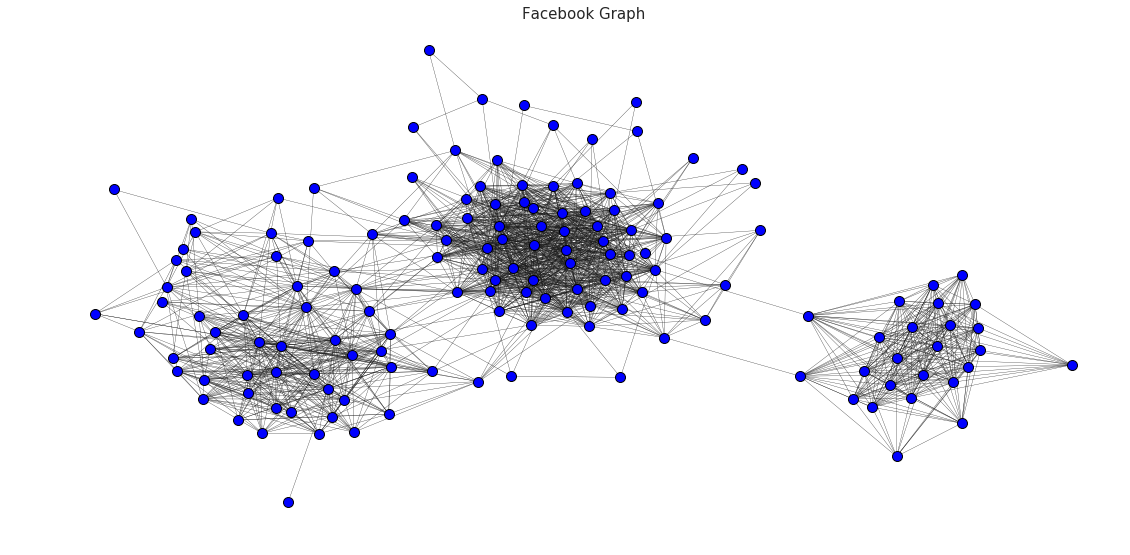

In [4]:
# if os.path.exists('facebook.tar.gz') is False:
#     resp = urllib.urlretrieve('https://snap.stanford.edu/data/facebook.tar.gz',
#                               'facebook.tar.gz')
#tarfile.open("facebook.tar.gz", 'r:gz').extractall('.')
fig = plt.figure(figsize=(15,7))
G_fb = nx.read_edgelist("facebook/414.edges")
n = G_fb.number_of_nodes()
m = G_fb.number_of_edges()
# on renumérote les noeuds de 0 à n-1
mapping=dict(zip(G_fb.nodes(), range(n)))
nx.relabel_nodes(G_fb, mapping, copy=False)
pos = nx.kamada_kawai_layout(G_fb)
# pos = nx.spring_layout(G_fb)

options = {
    'node_color': 'blue',
    'node_size': 100,
    'line_color': 'blue',
    'linewidths': 1,
    'width': 0.3,
}
nx.draw(G_fb, pos=pos, **options)
plt.gca().collections[0].set_edgecolor("#000000") # set node border color to black
plt.title("Facebook Graph", fontsize = 15)
print(" Graph Statistics ".center(70,"="))
print("Number of nodes :\t", n)
print("Number of edges :\t", m)
print("Number of components :\t",nx.number_connected_components(G_fb))
print("Average Clustering :\t", round(nx.average_clustering(G_fb),3))


#### Predicting

We will now try to predict links in the network. To do this, we start by extracting a proportion of the edges of the graph, whose existence we will try to predict among all the possible non-existent edges. The learning graph is the original graph from which the selected edges are removed.

In [5]:
'''
    G_fb_train  is a copy of the original graph 
    we removed randomly 20% of the edges
''' 

proportion_edges = 0.2
edge_subset = random.sample(G_fb.edges(),
                            int(proportion_edges * G_fb.number_of_edges()))
G_fb_train = G_fb.copy()
G_fb_train.remove_edges_from(edge_subset)

edge_subset_size = len(list(edge_subset))
print("Number of removed edges:\t %d" % edge_subset_size)
print("Number of remaining edges:\t %d" % (m - edge_subset_size))
print("Number of unexisting edges:\t %d" %
      len(list(nx.non_edges(G_fb_train))))

Number of removed edges:	 338
Number of remaining edges:	 1355
Number of unexisting edges:	 9820


We want to score the unexisting edges such as the removed edges have higher score. We used several similarities measures between nodes and calculate the AUC. Let's also plot the ROC curve for each similarity. 

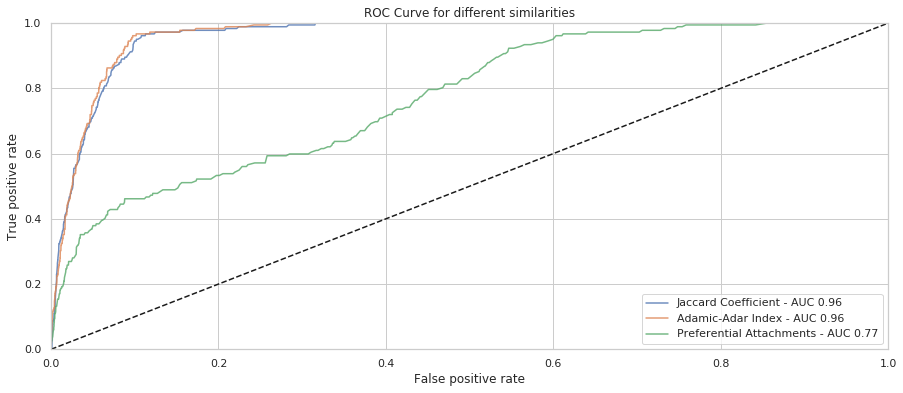

In [9]:
# Let's generarate score and labels (true or false edges) with jaccard
pred_jaccard = list(nx.jaccard_coefficient(G_fb_train))
score_jaccard, label_jaccard = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in pred_jaccard])
fpr_jaccard, tpr_jaccard, _ = metrics.roc_curve(label_jaccard, score_jaccard)
auc_jaccard = metrics.auc(fpr_jaccard, tpr_jaccard)

pred_adamic = list(nx.adamic_adar_index(G_fb_train))
score_adamic, label_adamic = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in pred_adamic])
fpr_adamic, tpr_adamic, _ = metrics.roc_curve(label_adamic, score_adamic)
auc_adamic = metrics.auc(fpr_adamic, tpr_adamic)

pred_pref = list(nx.preferential_attachment(G_fb_train))
score_pref, label_pref = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in pred_pref])
fpr_pref, tpr_pref, _ = metrics.roc_curve(label_pref, score_pref)
auc_pref = metrics.auc(fpr_pref, tpr_pref)

# Plot ROC curve and AUC
plt.figure(figsize=(15, 6))
plt.plot(fpr_jaccard, tpr_jaccard, label='Jaccard Coefficient - AUC %.2f' % auc_jaccard,
        alpha = 0.8)
plt.plot(fpr_adamic, tpr_adamic, label='Adamic-Adar Index - AUC %.2f' % auc_adamic, 
         alpha = 0.8)
plt.plot(fpr_pref, tpr_pref, label='Preferential Attachments - AUC %.2f' % auc_pref, 
         alpha = 0.8)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.title("ROC Curve for different similarities")
plt.show()

__Observation__:

In our given scenario, we clearly see that the Jaccard coefficient and Adamic-Adar index similarities are a better metric to predict the connection between nodes. 

We can explain this difference by the fact that Jaccard and A-A similarities are based on the number of commons neighbors between two nodes while the preferential attachment is only based on the number of neighbors (common or not) of each nodes. 

Indeed, it is easy to understand that on facebook, if two people are friends with the same people (therefore, have the same neighbors), it is highly likely that they are also friends (seems they hang out with the same people). That's why the Jaccard Coefficient and Adamic-Adex index similarities are so effective. 

On the contrary, it is not because two people have a lot of friends on facebook (common or not), that it is likely they know each other. That's why the Preferential attachments is not effective.  

#### Semi-supervised classification

We will now do semi-supervised classification of nodes. To do this, we will use the attributes that are provided with the ego-network. These attributes represent (anonymized) characteristics of network users. In the following we will use the attribute `43` which is `+1` (red) if the person studied in a given school, and `-1` (blue) if not.

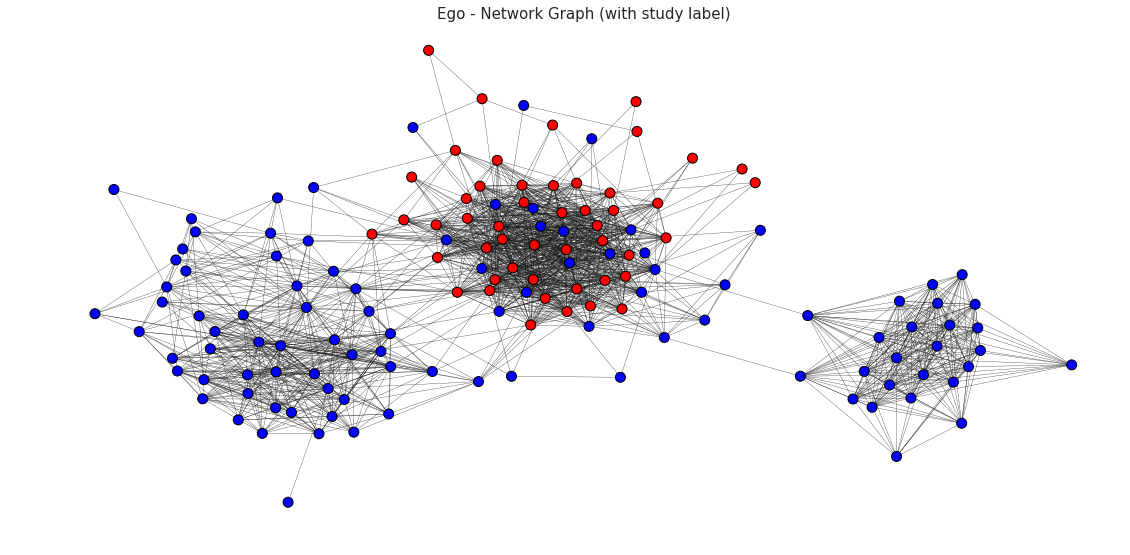

In [56]:
# Let's load and display the labels

with open('facebook/414.featnames') as f:
    for i, l in enumerate(f):
        pass

n_feat = i+1

features = np.zeros((n, n_feat))
f = open('facebook/414.feat', 'r')
for line in f:
    if line.split()[0] in mapping:
        node_id = mapping[line.split()[0]]
        features[node_id, :] = list(map(int, line.split()[1:]))

features = 2*features-1
feat_id = 43
labels = features[:, feat_id]
pos = nx.kamada_kawai_layout(G_fb)

options = {
    'node_color': labels,
    'node_size': 100,
    'line_color': "grey",
    'linewidths': 1,
    'width': 0.3,
    'nodelist' : range(n),
    'pos': pos,
    'cmap' : plt.get_cmap('bwr'),
}
plt.figure(figsize=(15,7))
nx.draw(G_fb, **options)
plt.gca().collections[0].set_edgecolor("#000000") # set node border color to black
plt.title("Ego - Network Graph (with study label)", fontsize = 15)
plt.show()

We see that our attributes is smooth on our graph, which helps is good  to propagate the labels. Let's ramdomly keep 20% of the labels on our nodes and try to predict the rest of the labels based on them. Let's watch the remaning labels.

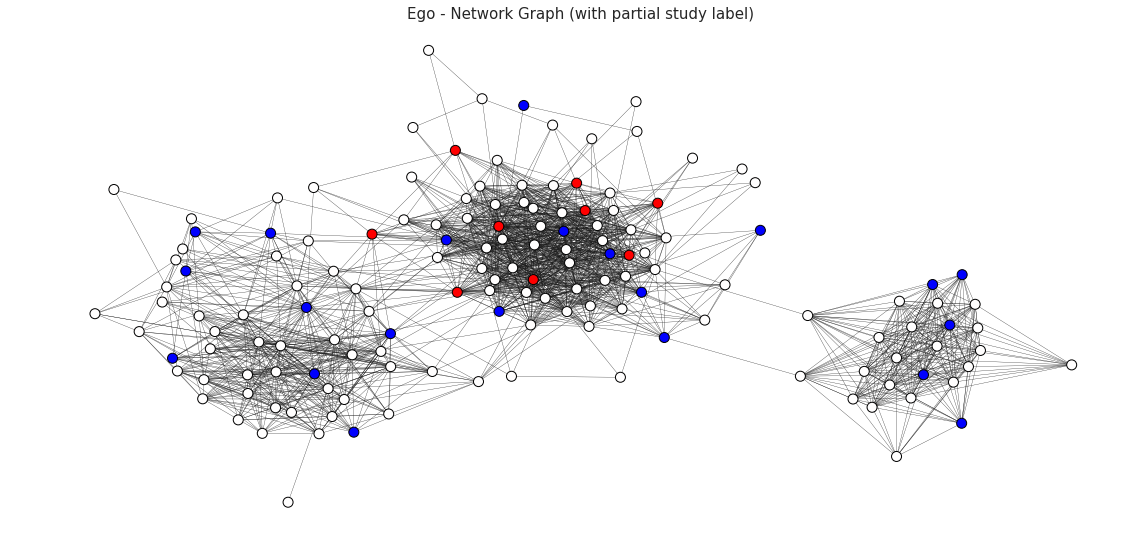

In [63]:
# We keep 20% of the labels on the nodes

random.seed(5)
proportion_nodes = 0.2
labeled_nodes = random.sample(G_fb.nodes(), int(proportion_nodes * G_fb.number_of_nodes()))

known_labels = np.zeros(n)
known_labels[labeled_nodes] = labels[labeled_nodes]

options = {
    'node_color': known_labels,
    'node_size': 100,
    'line_color': "grey",
    'linewidths': 1,
    'width': 0.3,
    'nodelist' : range(n),
    'pos': pos,
    'cmap' : plt.get_cmap('bwr'),
}

plt.figure(figsize=(15,7))
nx.draw(G_fb, **options)
plt.gca().collections[0].set_edgecolor("#000000") # set node border color to black
plt.title("Ego - Network Graph (with partial study label) ", fontsize = 15)
plt.show()

We will now apply the label propagation and see the results

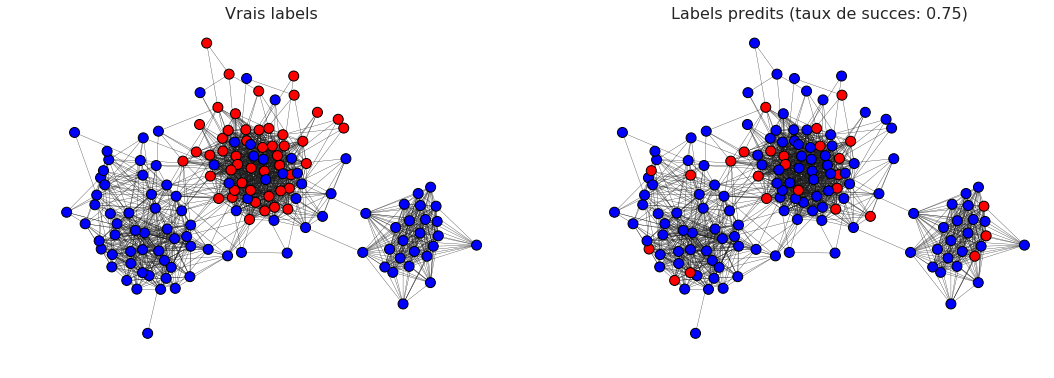

In [66]:
alpha = 0.7
L_sym = nx.normalized_laplacian_matrix(G_fb)

# on calcule la matrice de labels initiale
Y = np.zeros((n,2))
Y[known_labels==-1, 0] = 1
Y[known_labels==1, 1] = 1

# propagation de labels à faire ici

# labels prédits à mettre dans une variable F_pred pour affichage ci-dessous
F_pred = np.linalg.inv((1-alpha) * np.identity(n) + L_sym) @ Y
F_pred = np.array(np.argmax(F_pred, axis=1).reshape(n,))[0]
# taux de succes a mettre dans une variable pred pour affichage ci-dessous
sucess = known_labels == F_pred
pred = len(sucess[sucess == True])/ len(sucess)

plt.figure(figsize=(18, 6))
f, axarr = plt.subplots(1, 2, num=1)
plt.sca(axarr[0])
options = {
    'node_size': 100,
    'line_color': "grey",
    'linewidths': 1,
    'width': 0.3,
    'nodelist' : range(n),
    'pos': pos,
    'cmap' : plt.get_cmap('bwr'),
}
nx.draw(G_fb, node_color = labels, **options)
axarr[0].set_title('Vrais labels', size=16)
plt.gca().collections[0].set_edgecolor("#000000") # set node border color to black
plt.sca(axarr[1])
nx.draw(G_fb,node_color = F_pred, **options)
axarr[1].set_title('Labels predits (taux de succes: %.2f)' % pred, size=16)
plt.gca().collections[0].set_edgecolor("#000000") # set node border color to black